In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import sklearn.model_selection
import albumentations as A
import cv2
import csv
import itertools
import os
import time
from scipy import ndimage

from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import trimesh

torch.manual_seed(123)

In [2]:
data_path = Path('/home/mruddy/mydata/AMAAZE/raw_data')
for folder in os.listdir(str(data_path)):
    folder_split = folder.split('_')
    if folder_split[0] == 'SheaLevallois':
        SheaLevallois_path = data_path/folder
    if folder_split[0] == 'Bohunician':
        Bohunician_path = data_path/folder
    if folder_split[0] == 'PunchedBlade':
        PunchedBlade_path = data_path/folder

In [3]:
# extract SheaLevallois meshes
path = SheaLevallois_path
meshes = []
for file in tqdm(os.listdir(str(path))):
    mesh = trimesh.load_mesh(str(path/file))
    meshes.append((mesh, file))

# sort SheaLevallois meshes
length = len(meshes)
sorted_meshes = []
for idx in range(length):
    for mesh_pair in meshes:
        name = mesh_pair[1].split('.')[0]
        # last fragment of SheaLevallois
        if name == 'Core A':
            if idx == length-1:
                sorted_meshes.append(mesh_pair[0])
        else:
            if int(name[1:]) == idx:
                sorted_meshes.append(mesh_pair[0])
meshes = sorted_meshes

In [3]:
# extract Bohunician meshes
path = Bohunician_path
meshes = []
for file in tqdm(os.listdir(str(path))):
    mesh = trimesh.load_mesh(str(path/file))
    meshes.append((mesh, file))
    
# sort Bohunician meshes
length = len(meshes)
sorted_meshes = []
for idx in range(length):
    for mesh_pair in meshes:
        name = mesh_pair[1].split('.')[0]
        # last fragment of Bohunician
        if name == 'm_RemCore':
            if idx == length-1:
                sorted_meshes.append(mesh_pair[0])
        else:
            if int(name[3:]) == idx:
                sorted_meshes.append(mesh_pair[0])
meshes = sorted_meshes

In [4]:
# scale up mesh by a factor of alpha
# turn a mesh into a list of points (includes vertices and centers of faces)
def mesh_to_integer_points(mesh,alpha=4):
    points = alpha * mesh.vertices.view(np.ndarray)
    faces = mesh.faces.view(np.ndarray)
    centers = []
    for idx in range(faces.shape[0]):
        point_indices = faces[idx]
        point1 = points[point_indices[0]]
        point2 = points[point_indices[1]]
        point3 = points[point_indices[2]]
        centers.append([(point1[0] + point2[0]+ point3[0]) / 3,
                        (point1[1] + point2[1]+ point3[1]) / 3,
                        (point1[2] + point2[2]+ point3[2]) / 3])
    centers = np.array(centers)
    points = np.concatenate((points,centers))
    return(points.round())

# pad out image to desired (even) size
def pad_image(image, size):
    sizes = image.shape
    sizes = (int((size - sizes[0]) / 2), int((size - sizes[1]) / 2), int((size - sizes[2]) / 2))
    padded_image = np.pad(image, ((sizes[0],sizes[0]),(sizes[1],sizes[1]),(sizes[2],sizes[2])))
    return padded_image

# turn a list of points into a 3D image (hollow contours)
def points_to_images(point_lists,thickness=0):
    all_points = point_lists[0]
    for idx in range(len(point_lists) - 1):
        all_points = np.concatenate((all_points,point_lists[idx+1]))
    x, y, z = [i[0] for i in all_points], [i[1] for i in all_points], [i[2] for i in all_points]
    min_x, min_y, min_z = min(min(x),0), min(min(y),0), min(min(z),0)
    max_x, max_y, max_z = max(x)-min_x, max(y)-min_y, max(z)-min_z
    
    images = []
    new_point_lists = []
    for points in point_lists:
        points = points + np.array([-min_x,-min_y,-min_z])
        x, y, z = [i[0] for i in points], [i[1] for i in points], [i[2] for i in points]
        image = np.zeros((int(max_x + 1), int(max_y + 1),int(max_z + 1)))
        for idx in range(len(points)):
            image[(int(x[idx])-thickness):(int(x[idx])+thickness),
                  (int(y[idx])-thickness):(int(y[idx])+thickness),
                  (int(z[idx])-thickness):(int(z[idx])+thickness)] = 1
        widest = max(image.shape)
        size = (int(widest / 32) +1)*32
        image = pad_image(image, size)
        images.append(image)
        new_point_lists.append(points)

    return(images, new_point_lists)

# turn a hollow 2D image of a contour into a filled-in mask
def create_mask_2D(image):
    ret,thresh = cv2.threshold(255*np.array(image,dtype=np.uint8),127,255,0)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    img = cv2.drawContours(thresh, contours, -1, 255, thickness=-1)
    return img

# iterate the 2D mask function on a 3D image
def create_mask_3D(image):
    slices = image.shape[0]
    mask = np.zeros(image.shape)
    for i in range(slices):
        mask_slice = create_mask_2D(image[i])
        mask[i] = mask_slice
    return mask

# fill-in holes in a 2D image
def fill_holes(image):
    img = np.array(image / 255,dtype=np.uint8)
    contour,hier = cv2.findContours(img,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(img,[cnt],0,255,-1)
    return img

def combine_fragments(masks):
    # combine masks
    all_fragments_mask = np.zeros(masks[0].shape)
    for idx in range(len(masks)):
        all_fragments_mask = np.maximum(all_fragments_mask,masks[idx])
    
    # fill-in holes
    for idx in range(all_fragments_mask.shape[0]):
        filled_slice = fill_holes(all_fragments_mask[idx])
        all_fragments_mask[idx] = filled_slice
    return all_fragments_mask

In [5]:
# alpha = 1.5 for SheaLevallois
# alpha = 4.0 for Bohunician

point_lists = []
for mesh in tqdm(meshes):
    points = mesh_to_integer_points(mesh,alpha=4.0)
    point_lists.append(points)

In [6]:
images, point_lists = points_to_images(point_lists,thickness=1)

In [7]:
masks = []
for image in tqdm(images):
    mask = create_mask_3D(image)
    masks.append(mask)

## Sandbox

In [8]:
idx = 1
image = images[idx]
image.shape

(256, 255, 255)

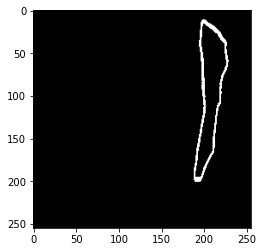

In [30]:
image_slice_no = 150
image_slice = image[image_slice_no]
plt.imshow(image_slice, cmap='gray')

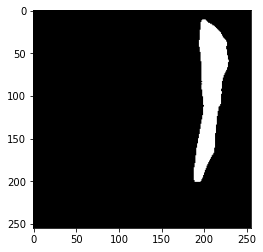

In [31]:
mask = masks[idx]
mask_slice = mask[image_slice_no]
plt.imshow(mask_slice,cmap='gray')

In [11]:
ret,thresh = cv2.threshold(255*np.array(image_slice,dtype=np.uint8),127,255,0)
contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
img = cv2.drawContours(thresh, contours, -1, 255, thickness=-1)

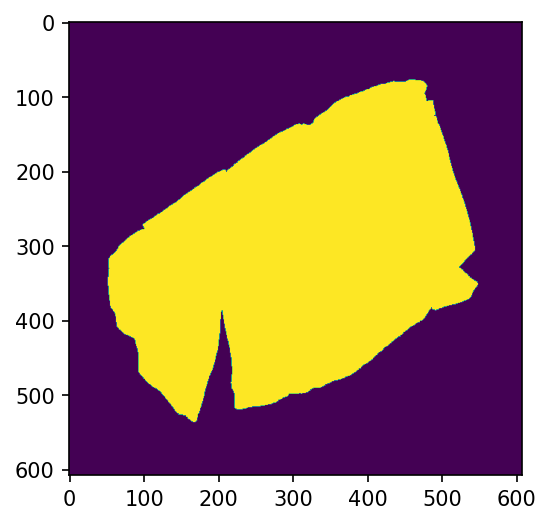

In [78]:
plt.imshow(img)

In [106]:
all_fragments = np.zeros(images[0].shape)
all_fragments_mask = np.zeros(images[0].shape)
for idx in tqdm(range(len(images))):
    all_fragments = np.maximum(all_fragments,images[idx])
    all_fragments_mask = np.maximum(all_fragments_mask,masks[idx])

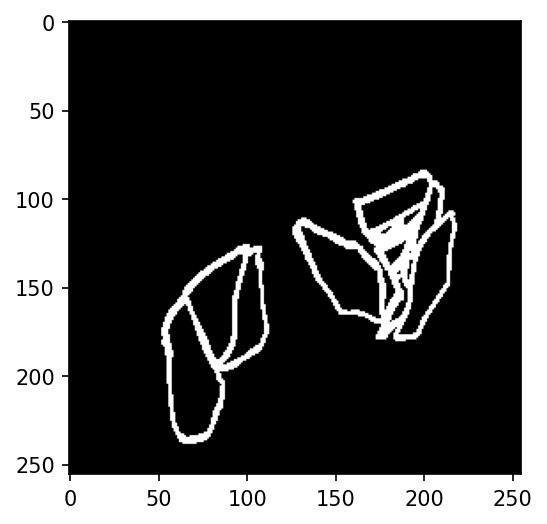

In [109]:
plt.rcParams['figure.dpi'] = 150
plt.imshow(all_fragments[50], cmap='gray')

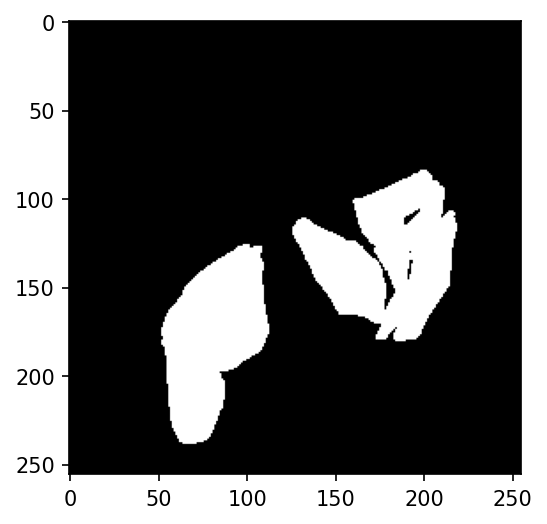

In [110]:
plt.rcParams['figure.dpi'] = 150
plt.imshow(all_fragments_mask[50], cmap='gray')

In [26]:
print(np.max(img))

255.0


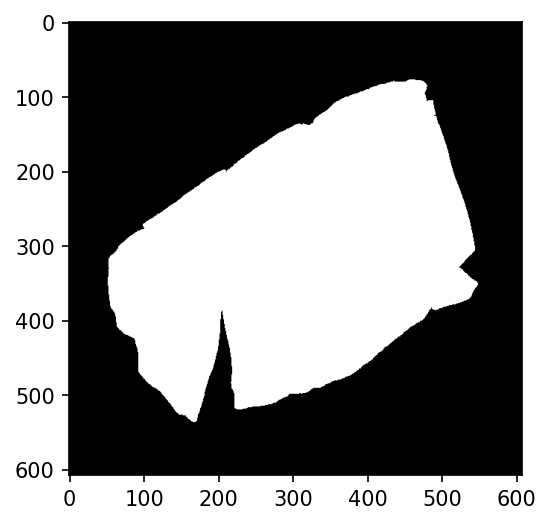

In [31]:
img = fill_holes(all_fragments_mask[250])
plt.imshow(img, cmap='gray')

## Process data

In [9]:
target_path = Path('/home/mruddy/mydata/AMAAZE/processed_data/SheaLevallois')
for idx in tqdm(range(len(masks))):
        
    fragment = masks[idx]
    fragment_list = masks[idx:]
    core = combine_fragments(fragment_list)
    
    # pad to (256,256,256)
    fragment = np.pad(fragment, ((0,1),(0,0),(0,1)))
    core = np.pad(core, ((0,1),(0,0),(0,1)))
    assert fragment.shape == (256,256,256)
    assert core.shape == (256,256,256)
    
    frag_fname = f'fragment{idx}'+'.npy'
    core_fname = f'core{idx}'+'.npy'
    
    # save
    np.save(str(target_path/frag_fname), fragment)
    np.save(str(target_path/core_fname), core)

In [9]:
target_path = Path('/home/mruddy/mydata/AMAAZE/processed_data/Bohunician')
for idx in tqdm(range(len(masks))):
    fragment = masks[idx]
    fragment_list = masks[idx:]
    core = combine_fragments(fragment_list)
    
    # pad to (256,256,256)
    fragment = np.pad(fragment, ((0,0),(0,1),(0,1)))
    core = np.pad(core, ((0,0),(0,1),(0,1)))
    assert fragment.shape == (256,256,256)
    assert core.shape == (256,256,256)
    
    frag_fname = f'fragment{idx}'+'.npy'
    core_fname = f'core{idx}'+'.npy'
    
    # save
    np.save(str(target_path/frag_fname), fragment)
    np.save(str(target_path/core_fname), core)